In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import random 

In [2]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    db_data = []
    db_cols = ['premise', 'hypothesis', 'label', 'predicted_scores', 'predicted_label']
    for d in data:
        db_data.append([])
        for col in db_cols:
            db_data[-1].append(d.get(col, float('nan')))
    return pd.DataFrame(db_data, columns=db_cols)

In [60]:
def print_analysis(df):
    print("Example premise: ", df.loc[2][0])
    print("Example hypothesis: ", df.loc[2][1])
    
    n = len(df)
    print("Accuracy: ", "%.3f" % (1 - sum(df['label']!=df['predicted_label'])/n))
    
    sizes = [sum(df['predicted_label']==i)/n for i in range(3)]
    labels = 'Entailment', 'Neutral', 'Contradiction'
    fig, ax = plt.subplots(figsize=(7,7))
    ax.pie(sizes, autopct='%1.1f%%', startangle=90)
    plt.legend(labels=labels)
    plt.title("Distribution of predicted labels")
    plt.show()
    

# Evaluation on SNLI validation set

Loaded 9842 records from eval_results/original_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  The men are fighting outside a deli.
Accuracy:  0.896


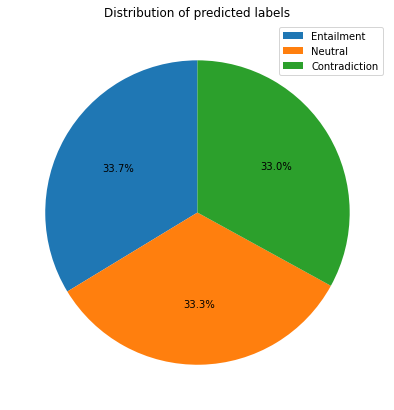

In [61]:
df_og = load_jsonl('eval_results/original_predictions.jsonl')
print_analysis(df_og)

# Evaluation on validation set with repeated hypotheses

All hypotheses from the default set were modified to repeat themselves once.

Loaded 9842 records from eval_results/repeat_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  The men are fighting outside a deli. The men are fighting outside a deli.
Accuracy:  0.496


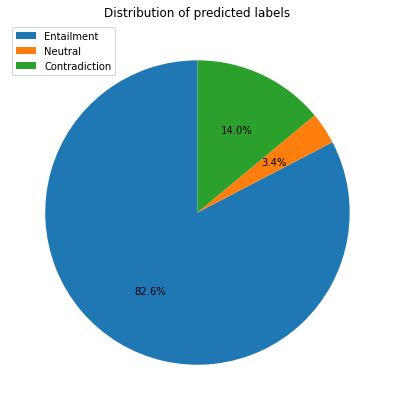

In [62]:
df_rp = load_jsonl('eval_results/repeat_predictions.jsonl')
print_analysis(df_rp)

The accuracy calculation assumes that the true labels do not change when the hypotheses are repeated. 

In [63]:
cont_to_ent = df_rp.index[(df_og['label']==2) & (df_og['predicted_label']==2) & (df_rp['predicted_label']==0)]
len(cont_to_ent)

1690

Here is an example that was correctly predicted as a contradiction in the original dataset but was switched to entailment in the repeated dataset. There were 1690 of such cases.

In [64]:
ex = cont_to_ent[random.randrange(len(cont_to_ent))]
print("Premise: ", df_og.loc[ex][0])
print()
print("Original hypothesis: ", df_og.loc[ex][1])
print("Predicted label: ", df_og.loc[ex][4])
print()
print("Repeated hypothesis: ", df_rp.loc[ex][1])
print("Predicted label: ", df_rp.loc[ex][4])

Premise:  This football team wears red shirts and red helmets.

Original hypothesis:  They are throwing ice cream at homeless people.
Predicted label:  2

Repeated hypothesis:  They are throwing ice cream at homeless people. They are throwing ice cream at homeless people.
Predicted label:  0


# Evaluation on nonsense set

All hypotheses from the validation set were changed to the same nonsense sentence: "The pizza goes to Jupiter on a rocket ship."

Loaded 9842 records from eval_results/nonsense_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  The pizza goes to Jupiter on a rocket ship. 
Accuracy:  1.000


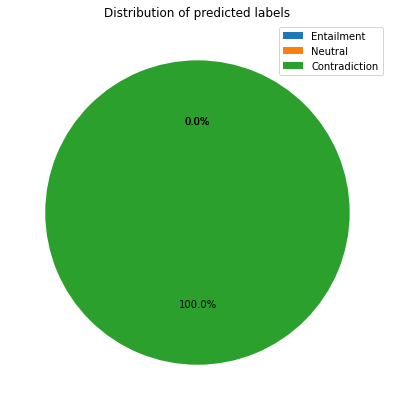

In [65]:
df_ns = load_jsonl('eval_results/nonsense_predictions.jsonl')
print_analysis(df_ns)

The accuracy calculation assumes that all true labels in this set are contradiction.

# Evaluation on nonsense set with nearly repeated hypotheses

Loaded 2000 records from eval_results/nonsense_near_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  The pizza goes to Jupiter on a rocket ship. The pizza goes to Jupiter on a rocket.
Accuracy:  0.949


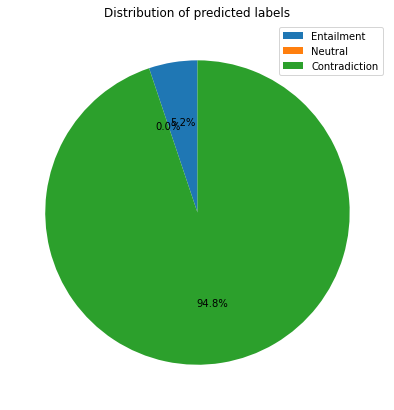

In [68]:
df_nsnr = load_jsonl('eval_results/nonsense_near_predictions.jsonl')
print_analysis(df_nsnr)

# Evaluation on nonsense set with repeated hypotheses

Loaded 9842 records from eval_results/nonsense_repeat_predictions.jsonl
Example premise:  Two women are embracing while holding to go packages.
Example hypothesis:  The pizza goes to Jupiter on a rocket ship. The pizza goes to Jupiter on a rocket ship. 
Accuracy:  0.001


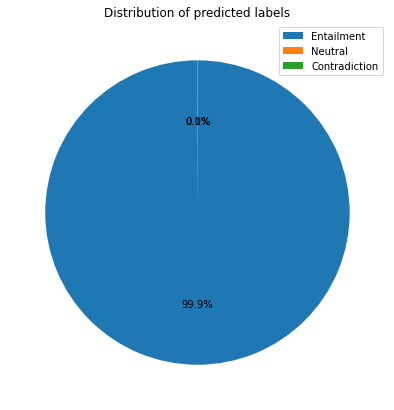

In [69]:
df_nsrp = load_jsonl('eval_results/nonsense_repeat_predictions.jsonl')
print_analysis(df_nsrp)

These were the only examples that were not predicted as entailment.

In [70]:
df_nsrp[df_nsrp['predicted_label'] != 0]

,premise,hypothesis,label,predicted_scores,predicted_label
7176,Two hikers rest on a snow-covered mountain.,The pizza goes to Jupiter on a rocket ship. Th...,2,"[0.776583731174469, -2.0964019298553467, 1.332...",2
7177,Two hikers rest on a snow-covered mountain.,The pizza goes to Jupiter on a rocket ship. Th...,2,"[0.7765837907791138, -2.0964014530181885, 1.33...",2
7178,Two hikers rest on a snow-covered mountain.,The pizza goes to Jupiter on a rocket ship. Th...,2,"[0.776583731174469, -2.0964019298553467, 1.332...",2
7182,"A man with a cowboy hat green plaid shirt, jea...",The pizza goes to Jupiter on a rocket ship. Th...,2,"[-0.10215122997760773, -2.0305941104888916, 2....",2
7183,"A man with a cowboy hat green plaid shirt, jea...",The pizza goes to Jupiter on a rocket ship. Th...,2,"[-0.10215119272470474, -2.0305941104888916, 2....",2
7184,"A man with a cowboy hat green plaid shirt, jea...",The pizza goes to Jupiter on a rocket ship. Th...,2,"[-0.10215122997760773, -2.0305941104888916, 2....",2
